In [1]:
from groupname.simulation.generator import VertexParticleGenerator
from groupname.simulation.detector import Detector
from groupname.visualization import EventDisplay
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from groupname.simulation.particle import CascadeParticle
import time


plt.rcParams['figure.figsize'] = (12, 9)

In [2]:
def analyze_event(event, threshold=10, distance_threshold=20):
    result = {'event_id': event.event_id}
    
    mask = event.pixels > threshold
    x = detector.pixel_x[mask]
    y = detector.pixel_y[mask]
    weights = event.pixels[mask]
    
    
    if not mask.any():
        return result
    
    idx = np.argmax(weights)
    
    result['x'] = x[idx]
    result['y'] = y[idx]
    
    dx = x - result['x']
    dy = y - result['y']
    
    distance = np.sqrt(dx**2 + dy**2)
    close = (distance < distance_threshold)
    
    
    x, y = x[close], y[close]
    dx, dy = dx[close], dy[close]
    weights = weights[close]
    
    # calculate pca
    cov = np.cov(x, y, aweights=weights)
    
    eigvals, eigvecs = np.linalg.eigh(cov)
    phi = np.arctan2(eigvecs[1, 1], eigvecs[1, 0])
    
    lon =    dx * np.cos(phi) + dy * np.sin(phi)
    trans = -dx * np.sin(phi) + dy * np.cos(phi) 
    
    skewness = np.average(lon**3, weights=weights) / eigvals[1]
    skewness2 = np.average(trans**3, weights=weights) / eigvals[0]
        
    if np.abs(skewness2) > np.abs(skewness):
        phi = np.arctan2(eigvecs[0, 1], eigvecs[0, 0])
        skewness = skewness2
    
    if skewness < 0:
        phi += np.pi
    
    while phi < 0:
        phi += 2 * np.pi
        
    while phi > (2 * np.pi):
        phi -= 2 * np.pi
    
    result['energy'] = np.sum(weights)
    result['direction'] = phi
    return result

In [3]:
rg = np.random.default_rng(42)

In [4]:
detector = Detector(
    noise_level=5,
    trigger_kernel_shape=(4, 4),
)

In [5]:
generator = VertexParticleGenerator(e_min=5e2, e_max=1e6, gamma=1.5)

In [6]:
t0 = time.perf_counter()
particles = generator.generate(100000, rg)
events = [detector.generate_event(p, rg) for p in particles]
triggered_events = [e for e in events if e.passed_trigger]

print('Simulation took', time.perf_counter() - t0, 's')

Simulation took 89.02525904699996 s


In [7]:
print(len(triggered_events) / len(events))

0.80397


{'event_id': 5, 'x': 38.28125, 'y': 88.28125, 'energy': 84622.62305196197, 'direction': 4.51283709645723}


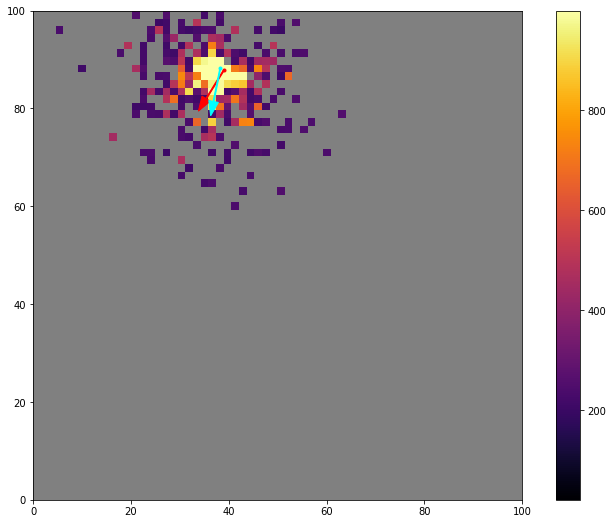

In [8]:
i = 4
event = triggered_events[i]
particle = event.particles[0]

threshold = 20
result = analyze_event(event, threshold=threshold, distance_threshold=20)
print(result)

plt.figure()
reco = CascadeParticle(
    x=result['x'], y=result['y'],
    direction=result['direction'],
    energy=result['energy'],
) 

cmap = plt.get_cmap('inferno')
cmap.set_under('gray')
d = EventDisplay(detector, event, cmap=cmap, vmin=threshold)
d.add_particle(particle, color='red')
d.add_particle(reco, color='cyan')
d.add_colorbar()

d.ax.figure.savefig('event.png', dpi=300)

In [9]:
t0 = time.perf_counter()

results = pd.DataFrame([analyze_event(e, threshold=20) for e in triggered_events])
truth = pd.DataFrame([e.particles[0].__dict__ for e in triggered_events])
df = results.join(truth, rsuffix='_true')

print(f'Analysis took {time.perf_counter() - t0:.2f} s')

/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in double_scalars


Analysis took 16.06 s


/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


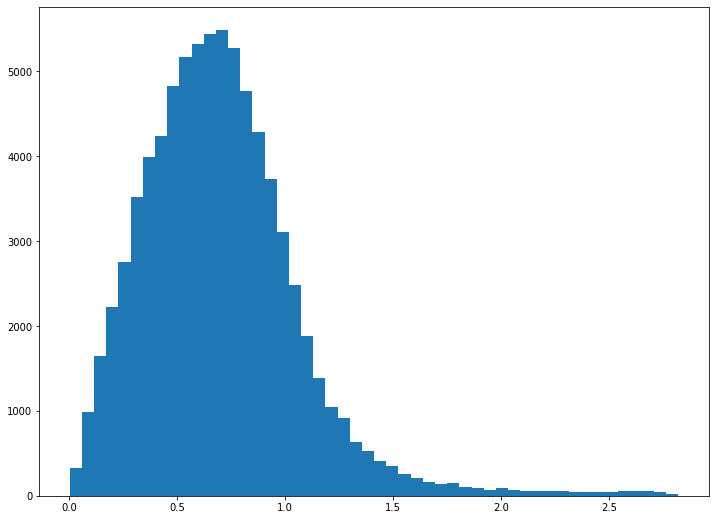

In [10]:
def dist(x0, y0, x1, y1):
    return np.sqrt((x0 - x1)**2 + (y0 - y1)**2)

dists = dist(df['x'], df['y'], df['x_true'], df['y_true'])
plt.hist(dists, range=np.nanpercentile(dists, [0,99]), bins=50)

None

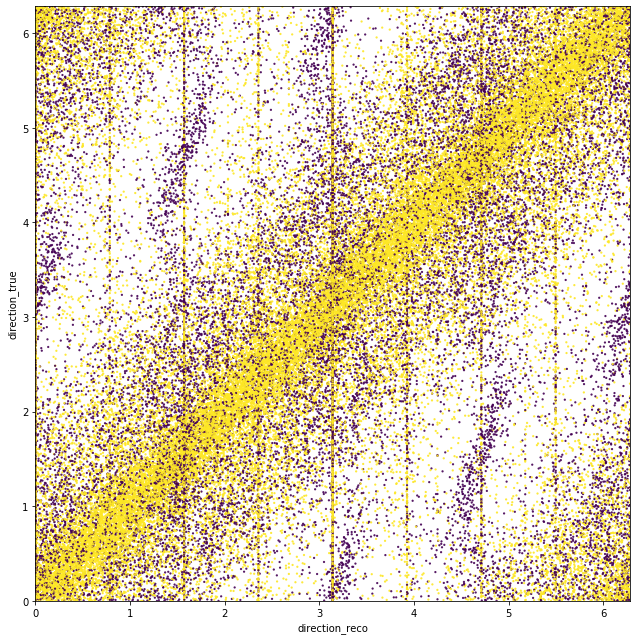

In [11]:
contained = df.eval('x > 10 and y > 10 and y < 90 and x < 90')


plt.scatter(
    df.direction,
    df.direction_true,
    c=contained, s=5, alpha=0.9, lw=0,
)

plt.gca().set_aspect(1)
plt.xlim(0, 2 * np.pi)
plt.ylim(0, 2 * np.pi)
plt.xlabel('direction_reco')
plt.ylabel('direction_true')
plt.tight_layout()
plt.savefig('direction_reco.png', dpi=300)


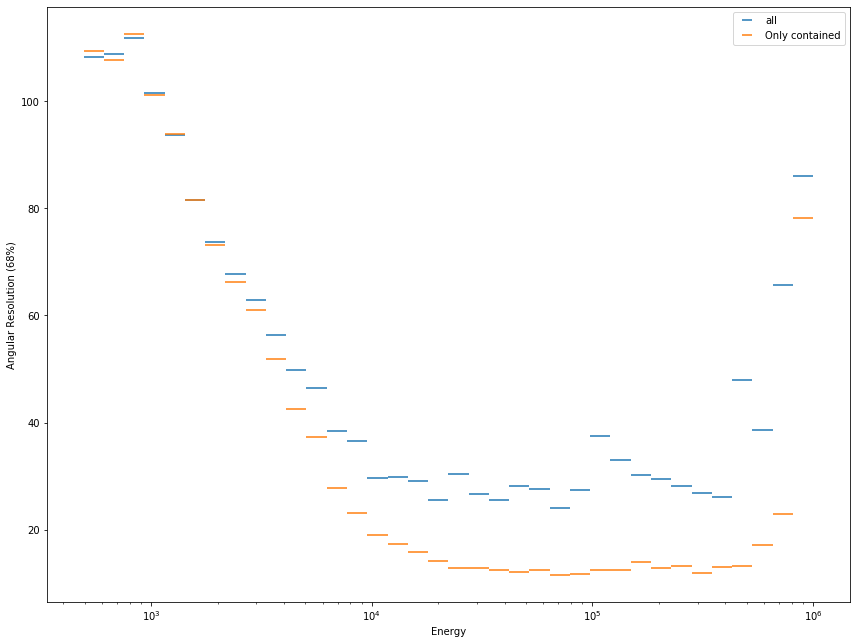

In [12]:

df['delta_ang'] = np.rad2deg(np.min(np.abs([
    df.direction - df.direction_true + delta
    for delta in (0, 2 * np.pi, - 2 * np.pi)
]), axis=0))

bins = np.concatenate([[0], np.logspace(1.5, 6, 50), [np.inf]])
centers = 0.5 * (bins[:-1] + bins[1:])
df['e_bin_true'] = np.digitize(df['energy_true'].to_numpy(), bins) - 1

r = pd.DataFrame({
    'centers': centers,
    'width': np.diff(bins),
    'low': bins[:-1],
    'high': bins[1:],
})

g = df[contained].groupby('e_bin_true')['delta_ang']
r['r68_contained'] = g.agg(lambda s: s.quantile(0.68))
r['n_contained'] = g.count()

g = df.groupby('e_bin_true')['delta_ang']
r['r68'] = g.agg(lambda s: s.quantile(0.68))
r['g'] = g.count()

plt.errorbar(
    r['centers'],
    r['r68'],
    xerr=r['width'] / 2,
    ls='None',
    label='all'
)

plt.errorbar(
    r['centers'],
    r['r68_contained'],
    xerr=r['width'] / 2,
    ls='None',
    label='Only contained',
)
plt.legend()
plt.ylabel('Angular Resolution (68%)')
plt.xlabel('Energy')
plt.tight_layout()
plt.xscale('log')
plt.savefig('angular_resolution.png', dpi=300)



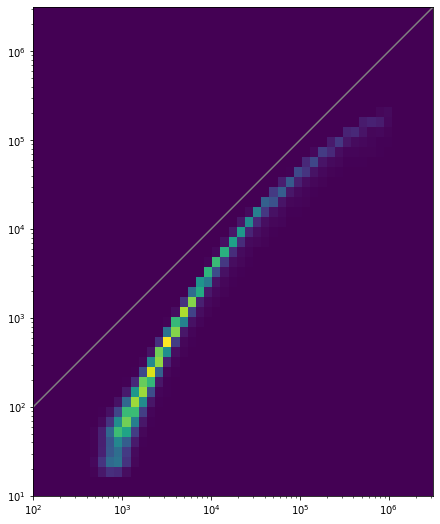

In [13]:
plt.hist2d(
    df['energy_true'],
    df['energy'],
    bins=[
        np.logspace(2, 6.5, 50),
        np.logspace(1, 6.5, 50),
    ],
)
plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect(1)
plt.plot([10**1.5, 10**6.5], [10**1.5, 10**6.5], color='gray')
plt.savefig('e_migration.png', dpi=300)
None

[   0    0    0    0    0    0    0    0    0    0    0    0    0 9660
 9286 8405 7375 6719 6014 5598 4911 4495 4093 3553 3269 2891 2645 2425
 2011 1904 1697 1516 1378 1230 1122 1034  893  810  713  710  609  543
  469  438  381  339  327  273  264]


/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
/home/maxnoe/.local/anaconda3/envs/smd/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


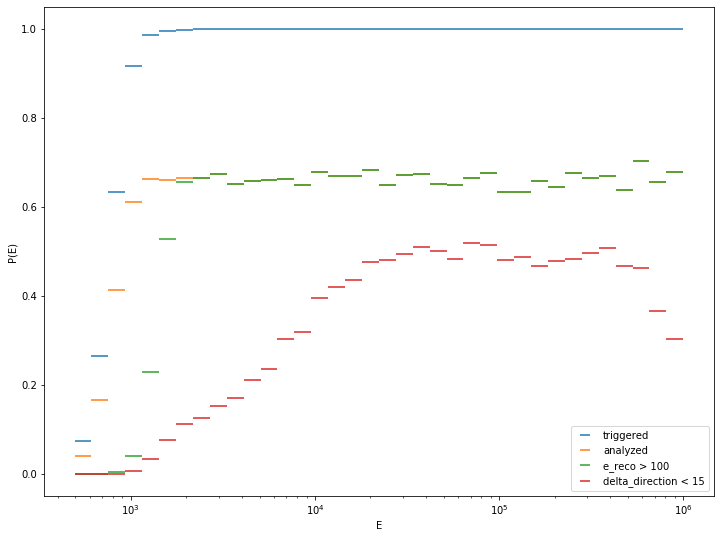

In [14]:
bins = np.logspace(1.5, 6, 50)
centers = 0.5 * (bins[:-1] + bins[1:])

min_e_reco = 100
max_delta_dir = 15
m_cont = contained.values
m_e = m_cont & (df.energy > min_e_reco)
m_s = m_e & (df.delta_ang < max_delta_dir)


n_simulated, _ = np.histogram([p.energy for p in particles], bins=bins)
n_triggered, _ = np.histogram([e.particles[0].energy for e in triggered_events], bins=bins)

n_analyzed, _ = np.histogram(df[m_cont].energy_true.dropna(), bins=bins)
n_above_e, _ = np.histogram(df[m_e].energy_true.dropna(), bins=bins)
n_source, _ = np.histogram(df[m_s].energy_true.dropna(), bins=bins)
print(n_simulated)


plt.errorbar(
    centers,
    n_triggered / n_simulated,
    xerr=np.diff(bins) / 2,
    ls='',
    label='triggered'
)


plt.errorbar(
    centers,
    n_analyzed / n_simulated,
    xerr=np.diff(bins) / 2,
    ls='',
    label='analyzed'
)

plt.errorbar(
    centers,
    n_above_e / n_simulated,
    xerr=np.diff(bins) / 2,
    ls='',
    label=f'e_reco > {min_e_reco}',
)


plt.errorbar(
    centers,
    n_source / n_simulated,
    xerr=np.diff(bins) / 2,
    ls='',
    label=f'delta_direction < {max_delta_dir}',
)

plt.legend()
plt.ylabel('P(E)')
plt.xlabel('E')
plt.xscale('log')
plt.savefig('detection_prob.png', dpi=300)